In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup # <-- 修改此行
import logging
from tqdm.notebook import tqdm
from peft import get_peft_model, LoraConfig

from pinyin_tokenizer import PinyinTokenizer
from stroke_tokenizer import StrokeTokenizer

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# 最终实验设置固定种子
set_seed(42)

In [3]:
import os
os.getcwd()

'/root'

In [4]:

import pandas as pd
import glob
import os
from sklearn.model_selection import train_test_split
import random

# 1. 加载并合并数据
data_root_path = 'autodl-tmp/Data_数据/'
file_paths = glob.glob(os.path.join(data_root_path, '**', '*.csv'), recursive=True)
if not file_paths:
    raise FileNotFoundError(f"在路径 {data_root_path} 下没有找到任何 .csv 文件。")

df_list = [pd.read_csv(p, encoding='gb18030') for p in file_paths]
df = pd.concat(df_list, ignore_index=True)

# 2. 清洗与格式化
df = df.rename(columns={'ask': 'query', 'answer': 'document'})
df.dropna(subset=['query', 'document', 'department'], inplace=True)
class_counts = df['department'].value_counts()
classes_to_keep = class_counts[class_counts > 1].index
df = df[df['department'].isin(classes_to_keep)]
print(f"数据加载与清洗完成: {len(df)} 条有效样本。")

# 3. 分层抽样
N = 50000
sample_size = min(N, len(df))
_, sampled_df = train_test_split(
    df, test_size=sample_size / len(df), stratify=df['department'], random_state=42
)
print(f"已通过分层抽样选取 {len(sampled_df)} 条样本用于实验。")
# [新增] 查看采样后各科室的样本分布
print("\n--- 抽样后数据集中各科室样本数分布 ---")
department_counts = sampled_df['department'].value_counts()
print(department_counts)
print("--- 分布情况显示完毕 ---\n")


all_data = sampled_df[['query', 'document']].to_dict('records')

# 4. 最终划分训练/验证集
train_data, val_data = train_test_split(all_data, test_size=0.1, random_state=42)
print(f"数据集划分: {len(train_data)} 条训练样本, {len(val_data)} 条验证样本。")


# 5. [修改] 定义并创建支持负采样的 TripletDataset
class TripletDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        anchor = self.data[idx]['query']
        positive = self.data[idx]['document']
        
        # 随机选择一个负样本
        while True:
            negative_idx = random.randint(0, len(self.data) - 1)
            # 确保负样本不是当前的正样本
            if negative_idx != idx:
                negative = self.data[negative_idx]['document']
                break
        
        return {"anchor": anchor, "positive": positive, "negative": negative}

train_dataset = TripletDataset(train_data)
val_dataset = TripletDataset(val_data)
print("TripletDataset 实例创建成功。")
import json

#  保存训练集和验证集到文件
# 将数据保存为 JSON 文件，以便评估时复用
with open('train_data_50k.json', 'w', encoding='utf-8') as f:
    json.dump(train_data, f, ensure_ascii=False, indent=2)

with open('val_data_50k.json', 'w', encoding='utf-8') as f:
    json.dump(val_data, f, ensure_ascii=False, indent=2)

print("\n训练集和验证集已分别保存到 train_data_50k.json 和 val_data_50k.json")

数据加载与清洗完成: 792098 条有效样本。
已通过分层抽样选取 50000 条样本用于实验。

--- 抽样后数据集中各科室样本数分布 ---
department
妇产科        7612
神经科        2957
消化科        2035
呼吸科        1763
内科         1619
           ... 
肠系膜动脉瘤        1
动脉导管未闭        1
精神疾病          1
外阴平滑肌肉瘤       1
关节科           1
Name: count, Length: 226, dtype: int64
--- 分布情况显示完毕 ---

数据集划分: 45000 条训练样本, 5000 条验证样本。
TripletDataset 实例创建成功。

训练集和验证集已分别保存到 train_data_50k.json 和 val_data_50k.json


In [5]:
# [替换此单元格]
import json
from torch.cuda.amp import autocast, GradScaler
# --- 模型架构 (不变) ---
class SiameseBERT(nn.Module):
    def __init__(self, pretrained_model_name='bert-base-chinese'):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model_name)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]
    def resize_token_embeddings(self, new_size):
        self.bert.resize_token_embeddings(new_size)

# --- Collate Function (不变) ---
def create_triplet_collate_fn(bert_tokenizer, custom_tokenizer=None, max_length=128):
    def collate_fn(batch):
        anchors = [item['anchor'] for item in batch]
        positives = [item['positive'] for item in batch]
        negatives = [item['negative'] for item in batch]
        def tokenize_text(texts):
            if custom_tokenizer:
                if hasattr(custom_tokenizer, 'text_to_strokes'): # 笔画
                    token_lists = [custom_tokenizer.text_to_strokes(t) for t in texts]
                else: # 拼音
                    token_lists = [[custom_tokenizer.id2token.get(i, '[UNK]') for i in custom_tokenizer.encode(t)] for t in texts]
                return bert_tokenizer(token_lists, is_split_into_words=True, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
            else:
                return bert_tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
        a_enc, p_enc, n_enc = tokenize_text(anchors), tokenize_text(positives), tokenize_text(negatives)
        return {
            'anchor_input_ids': a_enc['input_ids'], 'anchor_attention_mask': a_enc['attention_mask'],
            'positive_input_ids': p_enc['input_ids'], 'positive_attention_mask': p_enc['attention_mask'],
            'negative_input_ids': n_enc['input_ids'], 'negative_attention_mask': n_enc['attention_mask'],
        }
    return collate_fn

# --- 训练/验证循环 (最终版) ---
def train_loop(model, loader, optimizer, loss_fn, device, scheduler, scaler):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Training")
    for batch in progress_bar:
        optimizer.zero_grad()
        with autocast(enabled=True):
            anchor_vec = model(batch['anchor_input_ids'].to(device), batch['anchor_attention_mask'].to(device))
            positive_vec = model(batch['positive_input_ids'].to(device), batch['positive_attention_mask'].to(device))
            negative_vec = model(batch['negative_input_ids'].to(device), batch['negative_attention_mask'].to(device))
            loss = loss_fn(anchor_vec, positive_vec, negative_vec)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
    avg_loss = total_loss / len(loader)
    print(f"Epoch Average Training Loss: {avg_loss:.4f}")
    return avg_loss

def validation_loop(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Validation")
    with torch.no_grad():
        with autocast(enabled=True):
            for batch in progress_bar:
                anchor_vec = model(batch['anchor_input_ids'].to(device), batch['anchor_attention_mask'].to(device))
                positive_vec = model(batch['positive_input_ids'].to(device), batch['positive_attention_mask'].to(device))
                negative_vec = model(batch['negative_input_ids'].to(device), batch['negative_attention_mask'].to(device))
                loss = loss_fn(anchor_vec, positive_vec, negative_vec)
                total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    print(f"Epoch Average Validation Loss: {avg_loss:.4f}")
    return avg_loss

# --- 总实验流程 (最终版) ---
def run_experiment(mode, config, train_dataset, val_dataset, custom_tokenizer=None):
    print(f"--- Running Experiment: {mode} ---")
    print(f"Config: {config}")
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    scaler = GradScaler()
    history = {"train_loss": [], "val_loss": []}
    
    bert_tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
    model = SiameseBERT(pretrained_model_name=config['model_name'])
    if custom_tokenizer:
        token_lib = getattr(custom_tokenizer, 'stroke2id', getattr(custom_tokenizer, 'token2id', {})).keys()
        new_tokens = [t for t in token_lib if t not in bert_tokenizer.vocab]
        bert_tokenizer.add_tokens(new_tokens)
        model.resize_token_embeddings(len(bert_tokenizer))
    lora_config = LoraConfig(r=config.get('lora_r', 8), lora_alpha=config.get('lora_alpha', 16), target_modules=["query", "key", "value"], lora_dropout=0.1, bias="none")
    model = get_peft_model(model, lora_config)
    print("\nModel with LoRA applied:"); model.print_trainable_parameters(); model.to(DEVICE)
    
    collate_fn = create_triplet_collate_fn(bert_tokenizer, custom_tokenizer, max_length=config['max_length'])
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], collate_fn=collate_fn, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], collate_fn=collate_fn, num_workers=4, pin_memory=True)
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    loss_fn = nn.TripletMarginLoss(margin=1.0)
    
    num_training_steps = len(train_loader) * config['epochs']
    num_warmup_steps = int(num_training_steps * 0.1)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)
    print(f"Total training steps: {num_training_steps}, Warmup steps: {num_warmup_steps}")
    
    patience_counter, best_val_loss, best_epoch = 0, float('inf'), 0
    for epoch in range(config['epochs']):
        print(f"========== Epoch {epoch+1}/{config['epochs']} ==========")
        avg_train_loss = train_loop(model, train_loader, optimizer, loss_fn, DEVICE, scheduler, scaler)
        avg_val_loss = validation_loop(model, val_loader, loss_fn, DEVICE)
        history["train_loss"].append(avg_train_loss); history["val_loss"].append(avg_val_loss)
        if avg_val_loss < best_val_loss:
            best_val_loss, best_epoch, patience_counter = avg_val_loss, epoch + 1, 0
            torch.save(model.state_dict(), f'model_best_{mode}.pth'); print(f"Validation loss improved. Saving best model from epoch {best_epoch}.")
        else:
            patience_counter += 1; print(f"Validation loss did not improve. Patience: {patience_counter}/{config['patience']}")
        if patience_counter >= config['patience']:
            print("Early stopping triggered."); break
            
    print(f"\n--- Experiment {mode} Finished ---"); print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch}")
    results = {"config": config, "best_val_loss": best_val_loss, "best_epoch": best_epoch, "history": history}
    with open(f'results_{mode}.json', 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=4, ensure_ascii=False)
    print(f"Results for {mode} saved to results_{mode}.json")

In [6]:

# --- 实验配置中心 ---

COMMON_CONFIG = {
    'model_name': 'bert-base-chinese',
    'patience': 2,
    'lora_r': 8,
    'lora_alpha': 16,
}

EXPERIMENT_CONFIGS = {
    'baseline_lora': {
        'epochs': 10,
        'batch_size': 32, # 使用LoRA后，可以尝试更大的batch_size
        'lr': 1e-4,
        'max_length': 128,
        **COMMON_CONFIG
    },
    'pinyin_lora': {
        'epochs': 10,
        'batch_size': 32,
        'lr': 2e-4,
        'max_length': 256,
        **COMMON_CONFIG
    },
    'stroke_lora': {
        'epochs': 10,
        'batch_size': 8, # 序列最长，batch_size 谨慎设置
        'lr': 2e-4,
        'max_length': 256,
        **COMMON_CONFIG
    }
}

In [7]:
# --- Run Baseline Experiment ---
mode = 'baseline_lora'
run_experiment(
    mode=mode,
    config=EXPERIMENT_CONFIGS[mode],
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    custom_tokenizer=None
)

--- Running Experiment: baseline_lora ---
Config: {'epochs': 10, 'batch_size': 32, 'lr': 0.0001, 'max_length': 128, 'model_name': 'bert-base-chinese', 'patience': 2, 'lora_r': 8, 'lora_alpha': 16}


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Model with LoRA applied:
trainable params: 442,368 || all params: 102,710,016 || trainable%: 0.4307
Total training steps: 14070, Warmup steps: 1407
========== Epoch 1/10 ==========


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.2571


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.1112
Validation loss improved. Saving best model from epoch 1.
========== Epoch 2/10 ==========


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.1202


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.0929
Validation loss improved. Saving best model from epoch 2.
========== Epoch 3/10 ==========


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.1085


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.0910
Validation loss improved. Saving best model from epoch 3.
========== Epoch 4/10 ==========


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.1022


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.0905
Validation loss improved. Saving best model from epoch 4.
========== Epoch 5/10 ==========


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.0976


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.0941
Validation loss did not improve. Patience: 1/2
========== Epoch 6/10 ==========


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.0936


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.0950
Validation loss did not improve. Patience: 2/2
Early stopping triggered.

--- Experiment baseline_lora Finished ---
Best validation loss: 0.0905 at epoch 4
Results for baseline_lora saved to results_baseline_lora.json


In [8]:
 # --- Run Pinyin Experiment ---
mode = 'pinyin_lora'
pinyin_tokenizer = PinyinTokenizer()
run_experiment(
    mode=mode,
    config=EXPERIMENT_CONFIGS[mode],
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    custom_tokenizer=pinyin_tokenizer
)

--- Running Experiment: pinyin_lora ---
Config: {'epochs': 10, 'batch_size': 32, 'lr': 0.0002, 'max_length': 256, 'model_name': 'bert-base-chinese', 'patience': 2, 'lora_r': 8, 'lora_alpha': 16}


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Model with LoRA applied:
trainable params: 442,368 || all params: 102,716,160 || trainable%: 0.4307
Total training steps: 14070, Warmup steps: 1407
========== Epoch 1/10 ==========


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.8096


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.5969
Validation loss improved. Saving best model from epoch 1.
========== Epoch 2/10 ==========


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.5719


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.5170
Validation loss improved. Saving best model from epoch 2.
========== Epoch 3/10 ==========


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.4897


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.4237
Validation loss improved. Saving best model from epoch 3.
========== Epoch 4/10 ==========


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.4393


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.3717
Validation loss improved. Saving best model from epoch 4.
========== Epoch 5/10 ==========


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.4016


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.3672
Validation loss improved. Saving best model from epoch 5.
========== Epoch 6/10 ==========


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.3774


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.3196
Validation loss improved. Saving best model from epoch 6.
========== Epoch 7/10 ==========


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.3565


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.3146
Validation loss improved. Saving best model from epoch 7.
========== Epoch 8/10 ==========


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.3391


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.3187
Validation loss did not improve. Patience: 1/2
========== Epoch 9/10 ==========


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.3264


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.3010
Validation loss improved. Saving best model from epoch 9.
========== Epoch 10/10 ==========


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.3178


Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.3036
Validation loss did not improve. Patience: 1/2

--- Experiment pinyin_lora Finished ---
Best validation loss: 0.3010 at epoch 9
Results for pinyin_lora saved to results_pinyin_lora.json


In [9]:
# --- Run Stroke Experiment ---
mode = 'stroke_lora'
stroke_tokenizer = StrokeTokenizer(zh2text_file='autodl-tmp/zh2letter.txt')
run_experiment(
    mode=mode,
    config=EXPERIMENT_CONFIGS[mode],
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    custom_tokenizer=stroke_tokenizer
)

--- Running Experiment: stroke_lora ---
Config: {'epochs': 10, 'batch_size': 8, 'lr': 0.0002, 'max_length': 256, 'model_name': 'bert-base-chinese', 'patience': 2, 'lora_r': 8, 'lora_alpha': 16}


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Model with LoRA applied:
trainable params: 442,368 || all params: 102,710,016 || trainable%: 0.4307
Total training steps: 56250, Warmup steps: 5625
========== Epoch 1/10 ==========


Training:   0%|          | 0/5625 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.9769


Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.8579
Validation loss improved. Saving best model from epoch 1.
========== Epoch 2/10 ==========


Training:   0%|          | 0/5625 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.8060


Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.7142
Validation loss improved. Saving best model from epoch 2.
========== Epoch 3/10 ==========


Training:   0%|          | 0/5625 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.7061


Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.6524
Validation loss improved. Saving best model from epoch 3.
========== Epoch 4/10 ==========


Training:   0%|          | 0/5625 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch Average Training Loss: 0.6455


Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.5914
Validation loss improved. Saving best model from epoch 4.
========== Epoch 5/10 ==========


Training:   0%|          | 0/5625 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch Average Training Loss: 0.5989


Validation:   0%|          | 0/625 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch Average Training Loss: 0.5232


Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.4699
Validation loss improved. Saving best model from epoch 7.
========== Epoch 8/10 ==========


Training:   0%|          | 0/5625 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.4939


Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.4753
Validation loss did not improve. Patience: 1/2
========== Epoch 9/10 ==========


Training:   0%|          | 0/5625 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch Average Training Loss: 0.4791


Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.4476
Validation loss improved. Saving best model from epoch 9.
========== Epoch 10/10 ==========


Training:   0%|          | 0/5625 [00:00<?, ?it/s]

Epoch Average Training Loss: 0.4577


Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch Average Validation Loss: 0.4439
Validation loss improved. Saving best model from epoch 10.

--- Experiment stroke_lora Finished ---
Best validation loss: 0.4439 at epoch 10
Results for stroke_lora saved to results_stroke_lora.json


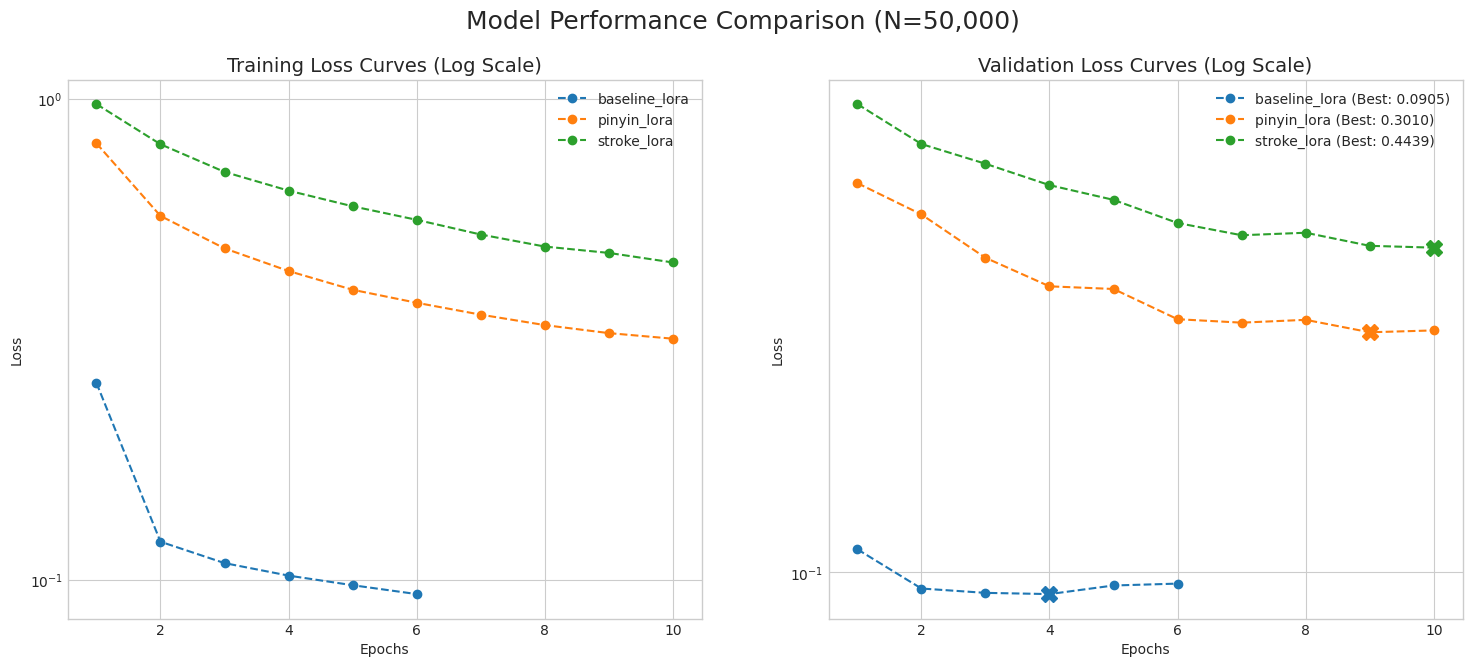


--- Final Results Summary (N=50,000) ---
| Model         |   Best Val Loss |   Best Epoch |
|:--------------|----------------:|-------------:|
| baseline_lora |       0.0905075 |            4 |
| pinyin_lora   |       0.300988  |            9 |
| stroke_lora   |       0.443868  |           10 |


In [11]:
# [替换此单元格]
import json
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os

# 1. 查找并加载所有实验结果文件
result_files = glob.glob('results_*.json')
all_results = []
for file_path in sorted(result_files):
    with open(file_path, 'r', encoding='utf-8') as f:
        result = json.load(f)
        mode_name = os.path.basename(file_path).replace('results_', '').replace('.json', '')
        result['mode_name'] = mode_name
        all_results.append(result)

# 2. 绘制 Loss 曲线
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# 绘制 Training Loss
for result in all_results:
    mode = result['mode_name']
    history = result['history']
    ax[0].plot(range(1, len(history['train_loss']) + 1), history['train_loss'], 'o--', label=f'{mode}')
ax[0].set_title('Training Loss Curves (Log Scale)', fontsize=14)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log') # <-- [新增] 将 Y 轴设置为对数刻度

# 绘制 Validation Loss
for result in all_results:
    mode = result['mode_name']
    history = result['history']
    best_epoch = result['best_epoch']
    best_loss = result['best_val_loss']
    line, = ax[1].plot(range(1, len(history['val_loss']) + 1), history['val_loss'], 'o--', label=f'{mode} (Best: {best_loss:.4f})')
    ax[1].plot(best_epoch, best_loss, 'X', markersize=12, color=line.get_color())
ax[1].set_title('Validation Loss Curves (Log Scale)', fontsize=14)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)
ax[1].set_yscale('log') # <-- [新增] 将 Y 轴设置为对数刻度

plt.suptitle('Model Performance Comparison (N=50,000)', fontsize=18)
plt.savefig('loss_curves_50k_log.png') # 保存图表
plt.show()

# 3. 打印最终结果表格 (不变)
summary_df = pd.DataFrame([{
    "Model": r['mode_name'],
    "Best Val Loss": r['best_val_loss'],
    "Best Epoch": r['best_epoch']
} for r in all_results]).sort_values(by="Best Val Loss")

print("\n--- Final Results Summary (N=50,000) ---")
print(summary_df.to_markdown(index=False))

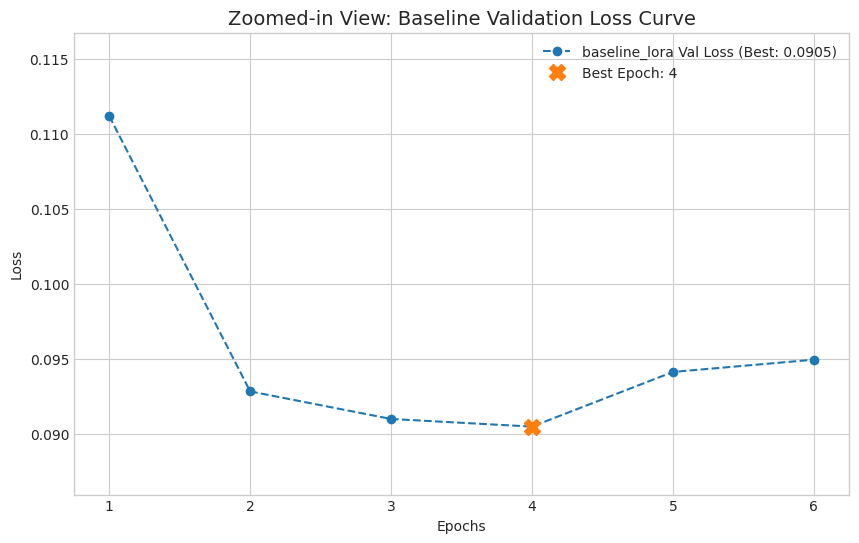

In [10]:
# [新增此单元格]
# 从已加载的结果中筛选出 baseline 的数据
baseline_result = next((r for r in all_results if r['mode_name'] == 'baseline_lora'), None)

if baseline_result:
    history = baseline_result['history']
    val_loss = history['val_loss']
    best_epoch = baseline_result['best_epoch']
    best_loss = baseline_result['best_val_loss']

    # 单独绘制 Baseline 的验证损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(val_loss) + 1), val_loss, 'o--', label=f'baseline_lora Val Loss (Best: {best_loss:.4f})')
    plt.plot(best_epoch, best_loss, 'X', markersize=12, label=f'Best Epoch: {best_epoch}')
    
    plt.title('Zoomed-in View: Baseline Validation Loss Curve', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    # 设置一个更精细的Y轴范围来放大细节
    plt.ylim(min(val_loss) * 0.95, max(val_loss) * 1.05)
    plt.xticks(range(1, len(val_loss) + 1)) # 确保每个epoch都有刻度
    plt.show()
else:
    print("未能找到 'baseline_lora' 的实验结果。")

In [1]:
!jupyter nbconvert --to html 主实验.ipynb

[NbConvertApp] Converting notebook 主实验.ipynb to html
[NbConvertApp] Writing 861724 bytes to 主实验.html
